# Car Overtaking
In this task, we design a nonlinear MPC on a kinematic bicycle car model to overtake the leading vehicle.


# System model

We assume the leading vehicle is cruising with velocity $\bar{v}_x$ along the center of a straight lane. Let the left hand side of the driving direction be the positive direction of $y$ and the $y$ position of leading vehicle as $0$. The yaw angle of the leading vehicle is $0$. 

The state of the ego vehicle is defined as the position with respect to the leading car $\left[x, y\right]$, yaw angle $\psi$, and the velocity $v$. The vehicle is controlled by the steering angle of front wheel $\delta$ and the acceleration $a$.

Thus, the dynamics of the vehicle can be expressed as:

$$
\frac{d}{dt} \begin{bmatrix} x \\ y \\ \psi \\ v \end{bmatrix}
= \begin{bmatrix} v\cos(\psi + \beta) - \bar{v}_x \\
                  v\sin(\psi + \beta)\\
                  \frac{v}{L_r} \sin\beta \\
                  a
  \end{bmatrix}, \text{with } \beta := \arctan(\frac{L_r}{L_r + L_f} \arctan \delta).
$$

where $L_r = L_f = 1.0$ is distance from the rear or front axles to the center of the vehicle. 

We apply the explicit Euler integration to obtain the discrete-time dynamics model of $\dot{s}=f(s, u) \ \ \text{as}\ \ s_{k+1} = s_{k} + f(s_k, u_k) \Delta t$. The state of the vehicle is $$s:=[x, y, \psi, v]^\top.$$

with control input:
$$
u:=[a, \delta]^\top. 
$$

In this task, we assume $\Delta t = 0.1 ~s$ in both simulation and controller design.


<div>
<img src="assets/takeover.png" width="800" align="left"/>
</div>

# Controller design:

The MPC controller designed here is of the following form to takeover the leading vehicle with desired velocity and go back to the same lane as the leading vehicle.

$
\begin{equation}
    \begin{aligned}
    \min_{s_k, u_k} & \ C1_{N} + C2_{N} + C3_{N} + \sum_{k=0}^{N-1} C1_{k} + C2_{k} + C3_{k} + C4_{k} \\ 
    \text{s.t. } & s_{k+1} = s_{k} + f(s_k, u_k) \Delta t, \ k = 0, \dots, N-1, \\
                 & Cons1_k, Cons2_k, Cons3_k, Cons4_k, \\
                 & s_0 = s_{init}.
    \end{aligned}
\end{equation}
$

## Cost function:
C1: Track a desired longitudinal velocity.

C2: Regularize the lateral velocity and yaw rate.

C3: Encourage the car to stay at the same lane as the leading vehicle. 

C4: Regularize the control inputs. 



## Constraints:

#### Cons1: Collision avoidance:
We consider a elliposoidal safety set for the vehicle when overtaking the car

$(\frac{x_k}{r_x})^2 + (\frac{y_k}{r_y})^2 - 1 \ge 0 $, 

We assign $r_x = 30 ~m, r_y = 2 ~m$.

#### Cons1: Maximum lateral acceleration
We restrict the lateral acceleration $a_y$ by:
$|a_y| \le 0.5 \mu g $, where $\mu$ is the coefficient of friction and $g$ is the gravity. 

The leteral acceleration is $ a_y = v \dot{\psi}$. 

$\dot{\psi}_{k} h = \psi_{k+1} - \psi_k $

We assume $\mu = 0.6$ and $g = 9.81 ~m / s^2$.

#### Cons2: Lane keeping
We restrict the car to only overtake using the left lane and do not cross the right lane (recommended in real driving too!).

$y_R \le y \le y_L$

We assume $y_L = 3m$ and $y_R = -1m$.

#### Cons3: Steering rate ####
The steering angle of the vehicle can not change too fast:

<!-- $|\delta_{k+1} - \delta_{k}| \le |\dot{\delta}|_{\max} \Delta t $ -->
$\|\dot{\delta}\| \le |\dot{\delta}|_{max} = 0.6 ~\text{rad}/s$. 

$\dot{\delta}_{k} h = \delta_{k+1} - \delta_k $


#### Cons4: Input bounds
The input is within the bounds:

$-10 ~m/s^2 = a_{\min} \le a \le a_{\max} = 4 ~m / s^2$

$-0.6 \text{rad} = \delta_{\min} \le \delta \le \delta_{\max} = 0.6 \text{rad} $

In [1]:
import casadi as ca
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import time

In [2]:
%load_ext autoreload
%autoreload 2

from nmpc_takeover import *

from utils import *

In [3]:
# Initial test case
x_init = np.array([-150., # x: x distance between our car and leader car
                0.0, # y: y distance between our car and leader car
                0.0, # yaw: yaw angle of our car
                50., # v: velocity of our car
                20., # v_x_leader: x velocity of leader car
                0.0, # v_y_leader: y velocity of leader car, fixed as 0. 
                60.0 # v_x_desired: desired takeover x velocity of our car
                ])      
xt, ut = eval_controller(x_init)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      244
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      244
                     variables with only upper bounds:        0
Total number of equality constraints.................:      164
Total number of inequality constraints...............:      280
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      280
        inequality constraints with only upper bounds:        0


Number of Iterations....: 54

     

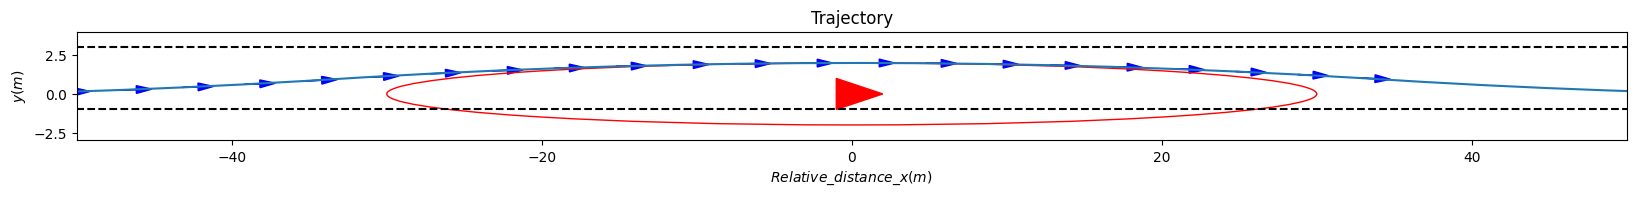

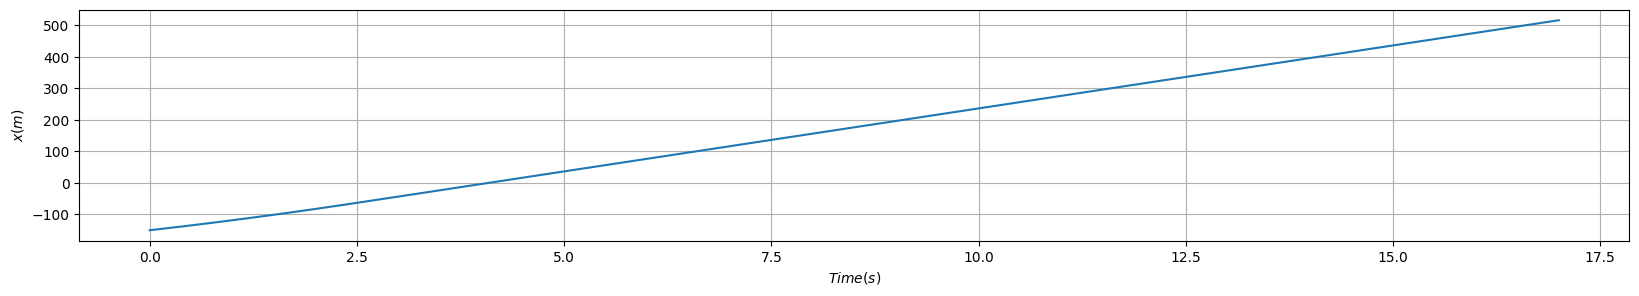

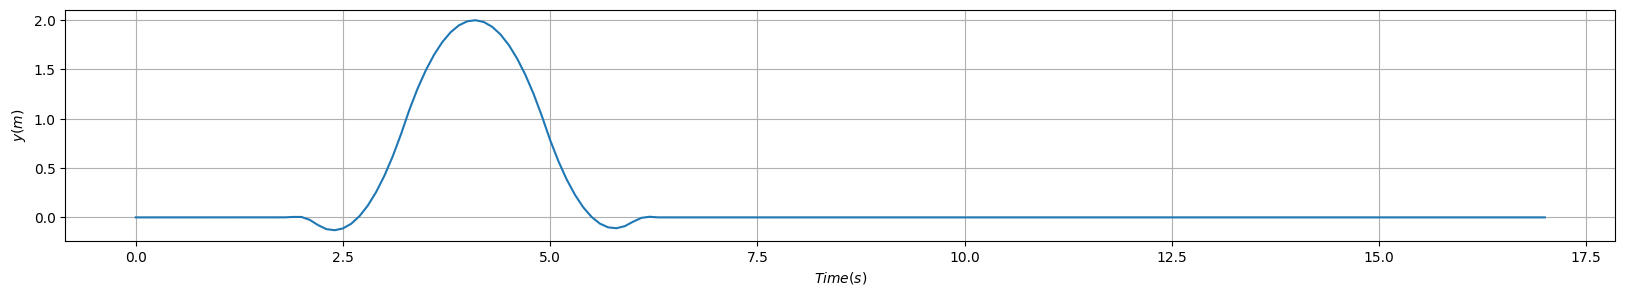

[ 0.00000000e+00  7.57940446e-10  3.12932962e-09  2.66156105e-10
  8.41695002e-11  1.44352787e-10  2.89414439e-10  1.60028142e-10
  2.67368117e-10  2.49124116e-10  5.23428131e-10  1.48129577e-09
 -5.52428214e-09 -9.63019204e-08  7.70744352e-07  6.58674134e-06
 -1.71729747e-05 -1.66223548e-04  3.76265634e-04  4.37432712e-03
  4.19108188e-03 -2.55569143e-02 -7.84549629e-02 -1.19019223e-01
 -1.30270914e-01 -1.12059559e-01 -6.43085859e-02  1.30136629e-02
  1.19912404e-01  2.56378137e-01  4.22393911e-01  6.17939614e-01
  8.42994214e-01  1.08797186e+00  1.30481540e+00  1.49227838e+00
  1.65034174e+00  1.77899214e+00  1.87822080e+00  1.94802257e+00
  1.98839510e+00  1.99933778e+00  1.98085037e+00  1.93293194e+00
  1.85558193e+00  1.74880103e+00  1.61259156e+00  1.44695756e+00
  1.25190456e+00  1.02743932e+00  7.83370453e-01  5.68713108e-01
  3.83472074e-01  2.27650980e-01  1.01252786e-01  4.27996499e-03
 -6.32654737e-02 -1.01382046e-01 -1.10068870e-01 -8.93257384e-02
 -4.42274784e-02 -4.88152

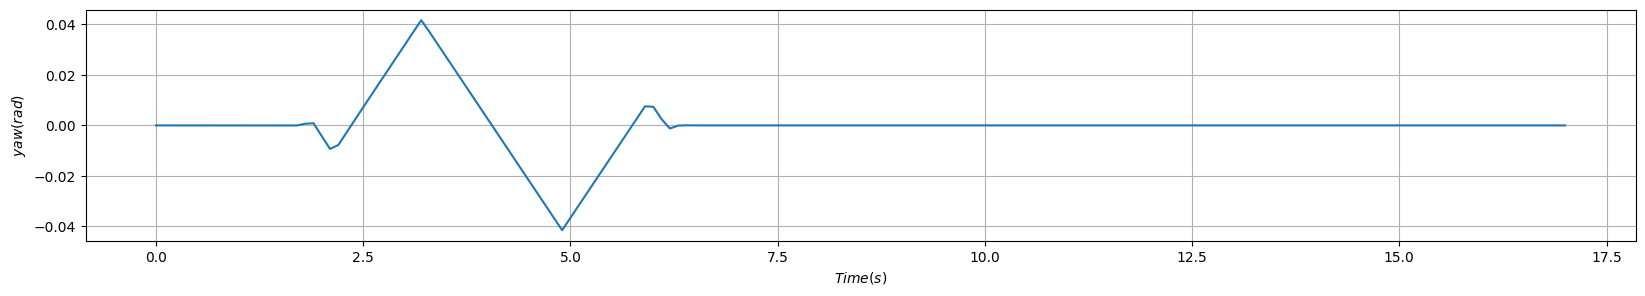

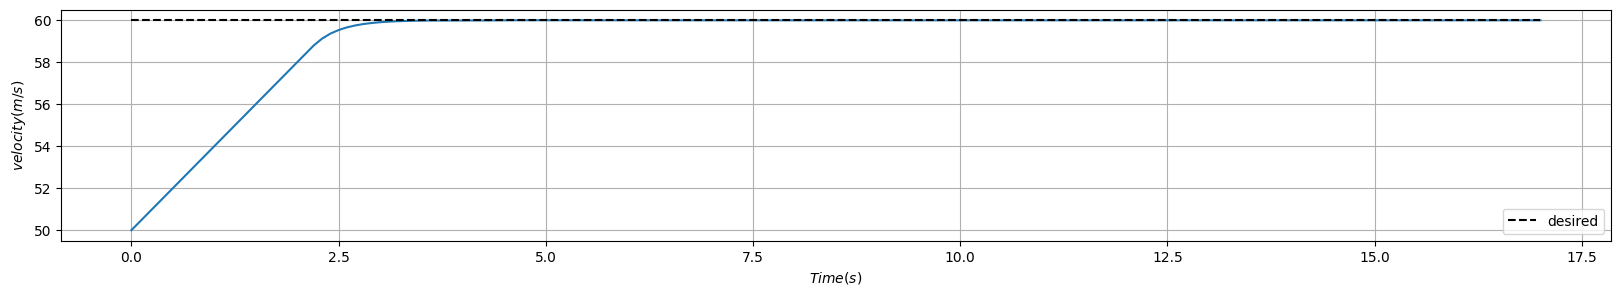

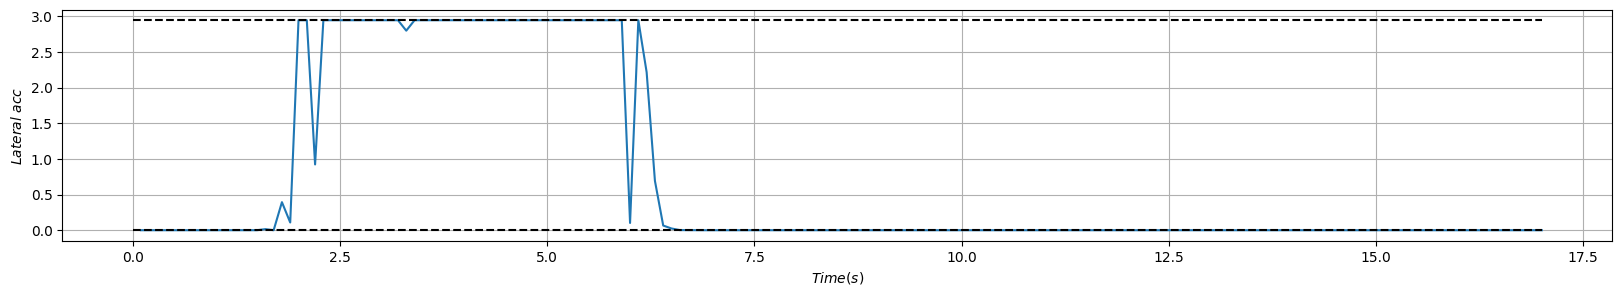

In [4]:
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon


### Maximum lateral acceleration ###
h = 0.1
gmu = 0.5 * 0.6 * 9.81
dx = (xt[1:, :] - xt[0:-1, :]) / h
ay = dx[:, 2] * xt[0:-1, 3]# dx[:, 3]
ay = np.abs(ay) - gmu



### Plot trajectory ###
x_w = xt[:, 0]
y_w = xt[:, 1]
yaw = xt[:, 2]
x0 = np.expand_dims(x_w, 1)
y0 = np.expand_dims(y_w, 1)
yaw = np.expand_dims(yaw, 1)
dx, dy = np.cos(yaw), np.sin(yaw)
arrows = np.concatenate((x0, y0, dx, dy), axis=1)[0:50, :]
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(x_w[0], y_w[0], "b.", markersize = 20)
for arrow in arrows:
    ax.arrow(arrow[0], arrow[1], arrow[2], arrow[3], head_width=0.5, head_length=1, fc='blue', ec='blue')
ax.plot(x_w, y_w)
ax.axis("scaled")
plt.title("Trajectory")
plt.xlabel("$Relative\_distance\_x(m)$")
plt.ylabel("$y(m)$")
plt.xlim((-50, 50))
plt.ylim((-3, 4))
# Define ellipse parameters
center_x = 0
center_y = 0
width = 60
height = 4
color = 'red'
fill = False
# Create an Ellipse object
ellipse = Ellipse((center_x, center_y), width, height, color=color, fill=fill)
# Add the ellipse to the axis
ax.add_patch(ellipse)
# Define the vertices of the triangle as a list of (x, y) coordinates
vertices = [(2, 0), (-1, 1), (-1, -1)]
# Create a Polygon patch using the vertices and add it to the axis
triangle = Polygon(vertices, closed=True, fill=True, color='r')
ax.add_patch(triangle)
# y constrain
plt.plot(x_w, 3*np.ones(x_w.shape), "--", color='black')
plt.plot(x_w, -1*np.ones(x_w.shape), "--", color='black')
plt.show()



### Plot x-t figure ###
t = np.linspace(0, 17, 171)
plt.figure(figsize=(20, 3))
plt.plot(t, xt[:, 0])
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$x(m)$")
plt.show()



### Plot y-t figure ###
plt.figure(figsize=(20, 3))
plt.plot(t, xt[:, 1])
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$y(m)$")
plt.show()
print(xt[:, 1])


### Plot yaw-t figure ###
plt.figure(figsize=(20, 3))
plt.plot(t, xt[:, 2])
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$yaw(rad)$")
plt.show()



### Plot v-t figure ###
plt.figure(figsize=(20, 3))
plt.plot(t, xt[:, 3])
plt.plot(t, t*0 + x_init[-1], "k--", label = "desired")
plt.legend()
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$velocity(m/s)$")
plt.show()



### Plot a-t figure ###
plt.figure(figsize=(20, 3))
plt.plot(t[1:], ay + (0.5 * 0.6 * 9.81))
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$Lateral\ acc$")
plt.plot(t, np.ones(t.shape)*0.5*0.6*9.81, 'k--')
plt.plot(t, -np.zeros(t.shape), 'k--')
plt.show()

# Now lets Animate the vehicles

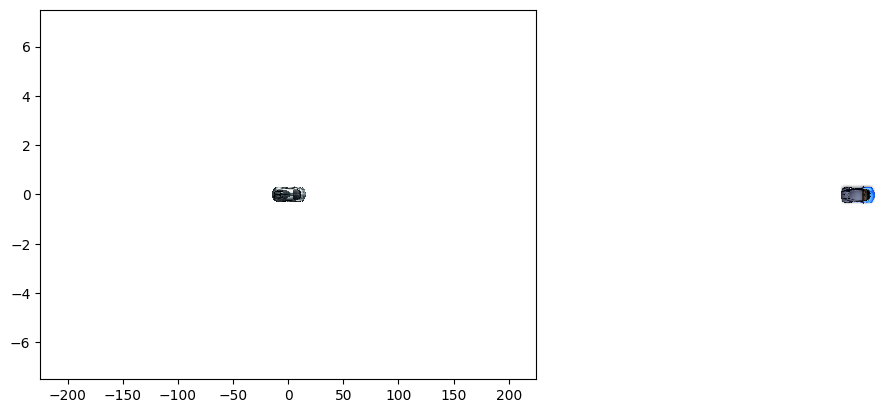

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.ndimage import rotate

ego_position_x = xt[:, 0]
ego_position_y = xt[:, 1]
ego_orientation = xt[:, 2]  # Orientation of the car

leading_position = np.zeros(len(ego_position_x)) ## This is zero because the ego_position is actually relative position of ego wrt leading




# Set up the figure and axis
fig, ax = plt.subplots()

ax.set_xlim(min(ego_position_x)-10, max(ego_position_x)+10)
ax.set_ylim(-3, 3)

# Load an image to use as the cursor (point)
ego_car_image = plt.imread(r'C:\Users\Lenovo\Downloads\SelfDriveSuite\Trajectory Optimization\CarOvertaking\assets\bugatti.jpg')
leading_car_image = plt.imread(r'C:\Users\Lenovo\Downloads\SelfDriveSuite\Trajectory Optimization\CarOvertaking\assets\bugatti-black.jpg')  

# Create OffsetImage objects for the moving images
ego_vehicle_image = OffsetImage(ego_car_image, zoom=0.04)
leading_vehicle_image = OffsetImage(leading_car_image, zoom=0.04)

# Create AnnotationBbox objects for placing the images on the plot
ego_vehicle_ab = AnnotationBbox(ego_vehicle_image, (ego_position_x[0], ego_position_y[0]), frameon=False)
leading_vehicle_ab = AnnotationBbox(leading_vehicle_image, (leading_position, 0), frameon=False)

# Add the AnnotationBbox objects to the axis
ax.add_artist(ego_vehicle_ab)
ax.add_artist(leading_vehicle_ab)

# Text for displaying time and distance information
distance_text = ax.text(0.05, 1.95, '', transform=ax.transAxes)

# Container for the AnnotationBbox objects
container = {
    'ego_vehicle_ab': ego_vehicle_ab,
    'leading_vehicle_ab': leading_vehicle_ab,
    'distance_text': distance_text
}


def init():
    container['ego_vehicle_ab'].xy = (ego_position_x[0], ego_position_y[0])
    container['leading_vehicle_ab'].xy = (leading_position[0], 0)
    # distance_text.set_text('')
    container['distance_text'].set_text('')
    return container['ego_vehicle_ab'], container['leading_vehicle_ab'], container['distance_text']

def update(frame):
    # Remove the previous AnnotationBbox objects
    container['ego_vehicle_ab'].remove()
    container['leading_vehicle_ab'].remove()

    # Rotate the car image based on the vehicle's orientation
    angle = np.rad2deg(ego_orientation[frame])
    rotated_image_array = rotate(ego_car_image, angle, reshape=True, mode='constant', cval=255)
    rotated_image = OffsetImage(rotated_image_array, zoom=0.04)
    
    # Create new AnnotationBbox objects with updated positions and orientation
    container['ego_vehicle_ab'] = AnnotationBbox(rotated_image, (ego_position_x[frame], ego_position_y[frame]), frameon=False)
    container['leading_vehicle_ab'] = AnnotationBbox(leading_vehicle_image, (leading_position[frame], 0), frameon=False)

    # Add the new AnnotationBbox objects to the axis
    ax.add_artist(container['ego_vehicle_ab'])
    ax.add_artist(container['leading_vehicle_ab'])

   
    # Update the text
    # distance_text.set_text(f'Distance between vehicles: {ego_position_x[frame]:.2f}m \n Ego velocity: {xt[frame, 3]+x_init[4]:.2f}, Leading velocity: {x_init[4]:.2f}')
    container['distance_text'].set_text(f'Distance between vehicles: {ego_position_x[frame]:.2f}m \nEgo velocity: {xt[frame, 3]+x_init[4]:.2f} m/s, Leading velocity: {x_init[4]:.2f} m/s')

    # Update the x-axis limits
    ax.set_xlim(leading_position[frame] - 225, leading_position[frame]+225)
    ax.set_ylim(-7.5, 7.5)

    return container['ego_vehicle_ab'], container['leading_vehicle_ab'], container['distance_text']

ani = animation.FuncAnimation(fig, update, frames=len(ego_position_y), init_func=init, interval=100, repeat=False)

# Save the animation
ani.save('vehicle_simulation.mp4', writer='ffmpeg')
